# Sentiment Analysis

## Lib & Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from transformers import AdamW
from transformers import AutoTokenizer, GPT2Model, AutoConfig

import time
from tqdm import tqdm

In [2]:
# use gpu to run the model if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Import Data

In [3]:
df = pd.read_csv('data/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## EDA

In [4]:
print("The Shape of the Dataset".format(),df.shape)
print(df['sentiment'].value_counts())

The Shape of the Dataset (50000, 2)
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


Visualization helps to determine an appropriate max_len for tokenizing text inputs

C:\Users\yauju\AppData\Local\Temp\ipykernel_28872\1899764959.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(count_zeros,ax=ax1,color='Blue')
C:\Users\yauju\AppData\Local\Temp\ipykernel_28872\1899764959.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(count_ones,ax=ax2,color='Red')


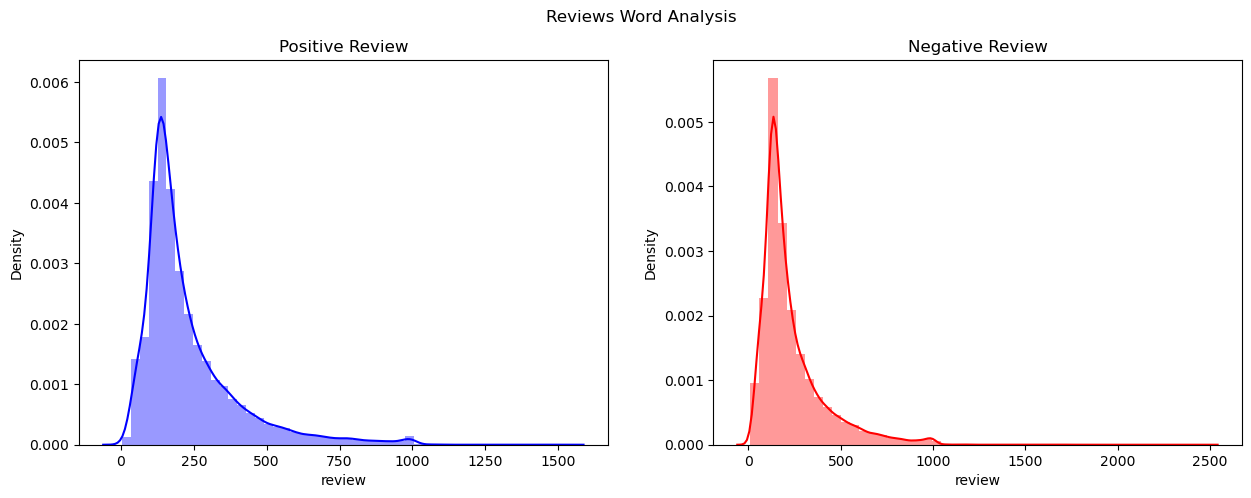

In [5]:
count_good = df[df['sentiment'] == 'positive']
count_bad = df[df['sentiment'] == 'negative']

# Calculate word count
def cal_len(data):
    return len(data)

# Plot the distribution of word counts
def plot_count(count_ones,count_zeros,title_1,title_2,subtitle):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    
    sns.distplot(count_zeros,ax=ax1,color='Blue')
    ax1.set_title(title_1)
    
    sns.distplot(count_ones,ax=ax2,color='Red')
    ax2.set_title(title_2)
    
    fig.suptitle(subtitle)
    plt.show()    
    

count_good_words = count_good['review'].str.split().apply(lambda z:cal_len(z))
count_bad_words = count_bad['review'].str.split().apply(lambda z:cal_len(z))

plot_count(count_good_words,count_bad_words,"Positive Review","Negative Review","Reviews Word Analysis")

## Data Cleaning

In [11]:
df.duplicated().sum()

418

In [12]:
df.drop_duplicates(inplace=True)

## Preprocessing

In [15]:
# Map sentiment labels to numeric values for the model to process the sentiment values as numeric targets
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)

## Model

In [17]:
# Custom class that inherits from GPT2Model for binary classification
class DistilGPT2ForBinaryClassification(GPT2Model):
    def __init__(self, num_labels):
        # Load the pre-trained config for distilgpt2
        config = AutoConfig.from_pretrained("distilgpt2")
        super().__init__(config)
        self.distil_gpt2 = GPT2Model.from_pretrained("distilgpt2", config=config)

        # Add a linear layer for binary classification
        self.classifier = nn.Linear(config.n_embd, 1)

        # Initialize the model
        self.post_init()

    def forward(self, input_ids, attention_mask=None):
        # Pass the input through the DistilGPT2 model to get the hidden states
        outputs = self.distil_gpt2(input_ids, attention_mask=attention_mask)

        # Extract the last hidden state from the model's output
        logits = self.classifier(outputs['last_hidden_state'][:,-1,:])

         # Apply sigmoid activation to get probabilities
        probabilities = torch.sigmoid(logits)
        return probabilities

In [19]:
class IMDbDataset(Dataset):
    def __init__(self, reviews, sentiments, tokenizer, max_len):
        self.reviews = reviews
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews.iloc[idx]
        sentiment = self.sentiments.iloc[idx]

        # Tokenize the review text using the tokenizer
        encoding = self.tokenizer.encode_plus(
            review,
            truncation=True, # Truncate the review to fit within the maximum length
            add_special_tokens=True, # Add special tokens for padding
            max_length=self.max_len, # Limit the sequence to `max_len` tokens
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt' # Return the tokenized output as PyTorch tensors
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'sentiment': torch.tensor(sentiment, dtype=torch.long)
        }

# Load the pre-trained tokenizer for 'distilgpt2'
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilgpt2")

# Set the padding token to be the same as the end-of-sequence (EOS) token
tokenizer.pad_token = tokenizer.eos_token

D:\Conda\envs\sc4001env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [20]:
MAX_LEN = 256
BATCH_SIZE = 32

train_dataset = IMDbDataset(X_train, y_train, tokenizer, MAX_LEN)
test_dataset = IMDbDataset(X_test, y_test, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [23]:
model = DistilGPT2ForBinaryClassification(2)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

# BCEWithLogitsLoss as the loss function for binary classification
def loss_fn(outputs, targets):
    return nn.BCEWithLogitsLoss()(outputs, targets)

D:\Conda\envs\sc4001env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
print(model)

DistilGPT2ForSequenceClassification(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-5): 6 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2SdpaAttention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (distil_gpt2): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementw

In [26]:
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    train_loss = 0
    correct_predictions = 0

    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiments = batch['sentiment'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.squeeze(), sentiments.type(torch.float))
        
        train_loss += loss.item() 
        correct_predictions += ((outputs.squeeze() > 0.5).type(torch.float) == sentiments).type(torch.float).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return correct_predictions / len(data_loader.dataset), train_loss / len(data_loader)

# Evaluation function
def evaluate_model(model, data_loader, device):
    model.eval()
    test_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            sentiments = batch['sentiment'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.squeeze(), sentiments.type(torch.float))
            
            test_loss += loss.item() 
            correct_predictions += ((outputs.squeeze() > 0.5).type(torch.float) == sentiments).type(torch.float).sum().item()

    return correct_predictions / len(data_loader.dataset), test_loss / len(data_loader)

In [27]:
EPOCHS = 3

times = []
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    start_time = time.time()
    
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f'Train loss: {train_loss}, accuracy: {train_acc}')
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    
    test_acc, test_loss = evaluate_model(model, test_loader, device)
    print(f'Test loss: {test_loss}, accuracy: {test_acc}')
    test_accs.append(test_acc)
    test_losses.append(test_loss)
    
    time_taken = time.time()-start_time
    print(f'time taken: {time_taken}')
    times.append(time_taken)

Epoch 1/3


100%|██████████████████████████████████████████████████████████████████████████████| 1240/1240 [32:45<00:00,  1.58s/it]


Train loss: 0.5816633313173248, accuracy: 0.8202697592335813
Test loss: 0.5581776089245273, accuracy: 0.8710295452253706
time taken: 2115.453093290329
Epoch 2/3


100%|██████████████████████████████████████████████████████████████████████████████| 1240/1240 [33:30<00:00,  1.62s/it]


Train loss: 0.5553149865038933, accuracy: 0.8855161981595865
Test loss: 0.5536831722144158, accuracy: 0.8884743369970757
time taken: 2157.3372898101807
Epoch 3/3


100%|██████████████████████████████████████████████████████████████████████████████| 1240/1240 [33:28<00:00,  1.62s/it]


Train loss: 0.5509641444731144, accuracy: 0.8952729106264969
Test loss: 0.5556360469710442, accuracy: 0.8715337299586569
time taken: 2155.3223106861115


In [49]:
# Evaluate the model on test set
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiments = batch['sentiment'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        y_pred.extend((outputs.squeeze() > 0.5).type(torch.float).cpu().numpy())
        y_true.extend(sentiments.cpu().numpy())

# Print classification report
print(classification_report(y_true, y_pred, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.82      0.96      0.88      4939
    positive       0.95      0.79      0.86      4978

    accuracy                           0.87      9917
   macro avg       0.88      0.87      0.87      9917
weighted avg       0.88      0.87      0.87      9917



In [50]:
model.save_pretrained("./saved_model/model_distilgpt2/")

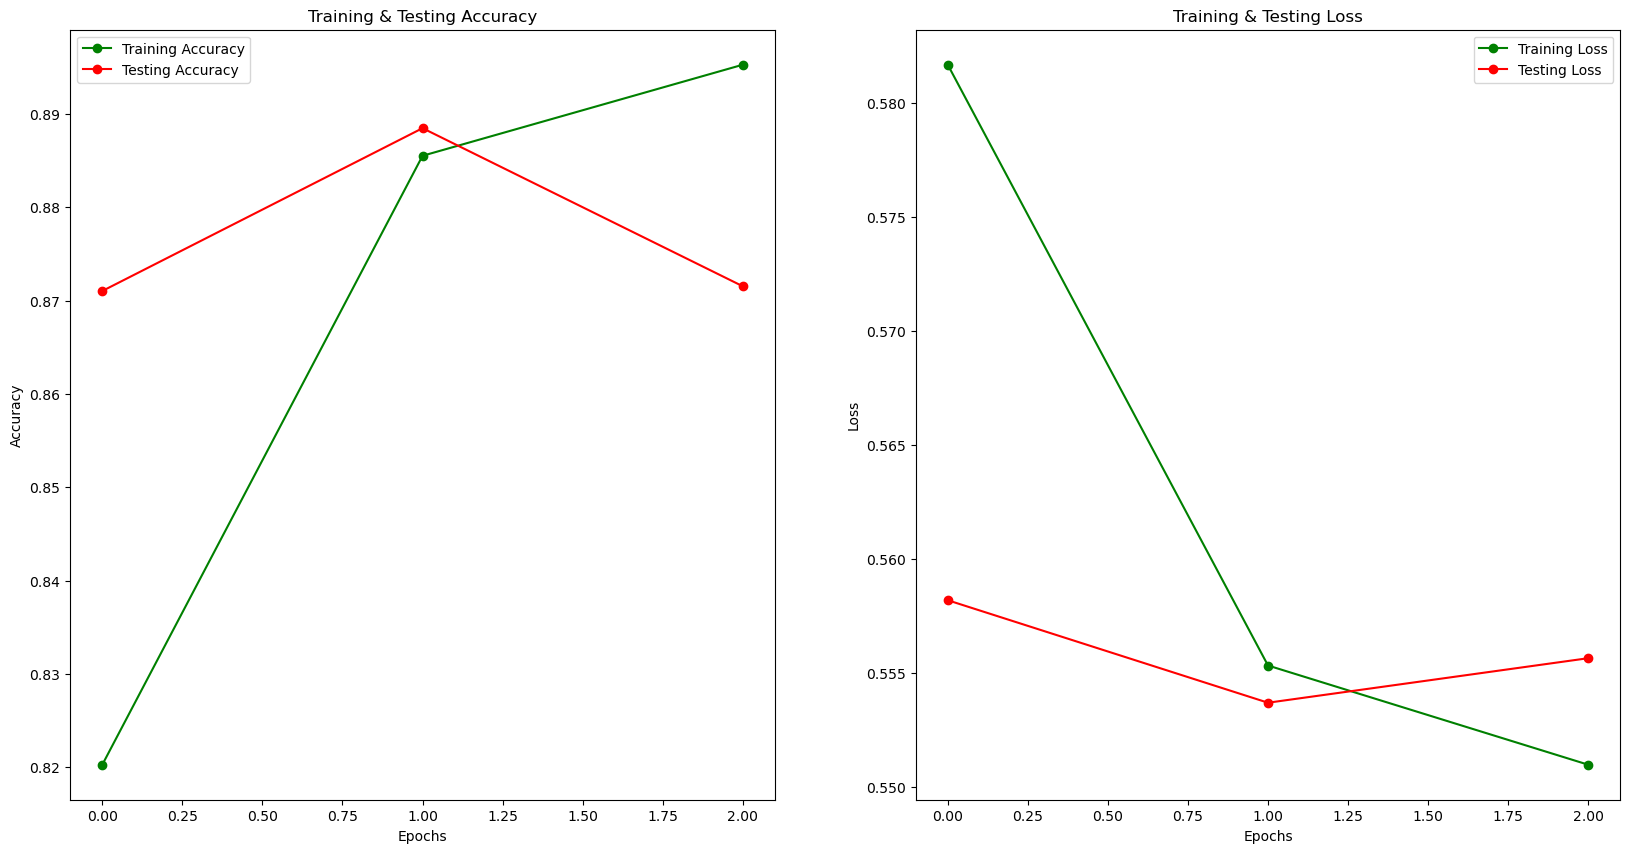

In [51]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_accs, 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , test_accs, 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_losses , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , test_losses , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [52]:
print(f'train_accs: {train_accs}')
print(f'test_accs: {test_accs}')
print(f'train_losses: {train_losses}')
print(f'test_losses: {test_losses}')

train_accs: [0.8202697592335813, 0.8855161981595865, 0.8952729106264969]
test_accs: [0.8710295452253706, 0.8884743369970757, 0.8715337299586569]
train_losses: [0.5816633313173248, 0.5553149865038933, 0.5509641444731144]
test_losses: [0.5581776089245273, 0.5536831722144158, 0.5556360469710442]


Text(95.72222222222221, 0.5, 'Actual')

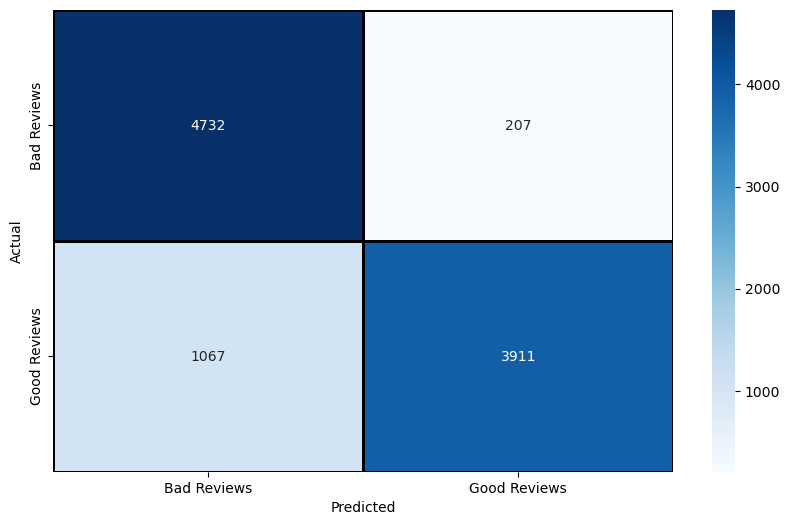

In [53]:
cm = confusion_matrix(y_true,y_pred)
plt.figure(figsize = (10,6))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Bad Reviews','Good Reviews'] , yticklabels = ['Bad Reviews','Good Reviews'])
plt.xlabel("Predicted")
plt.ylabel("Actual")